Starting SVM classification script...
Generating dataset with 1000 samples, 2 features, 2 classes.
Data preprocessing completed.
Training and evaluating SVM with linear kernel.
Training SVM model with linear kernel...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters for linear kernel: {'C': 1, 'class_weight': None, 'gamma': 'scale'}
Best cross-validation score: 0.9925


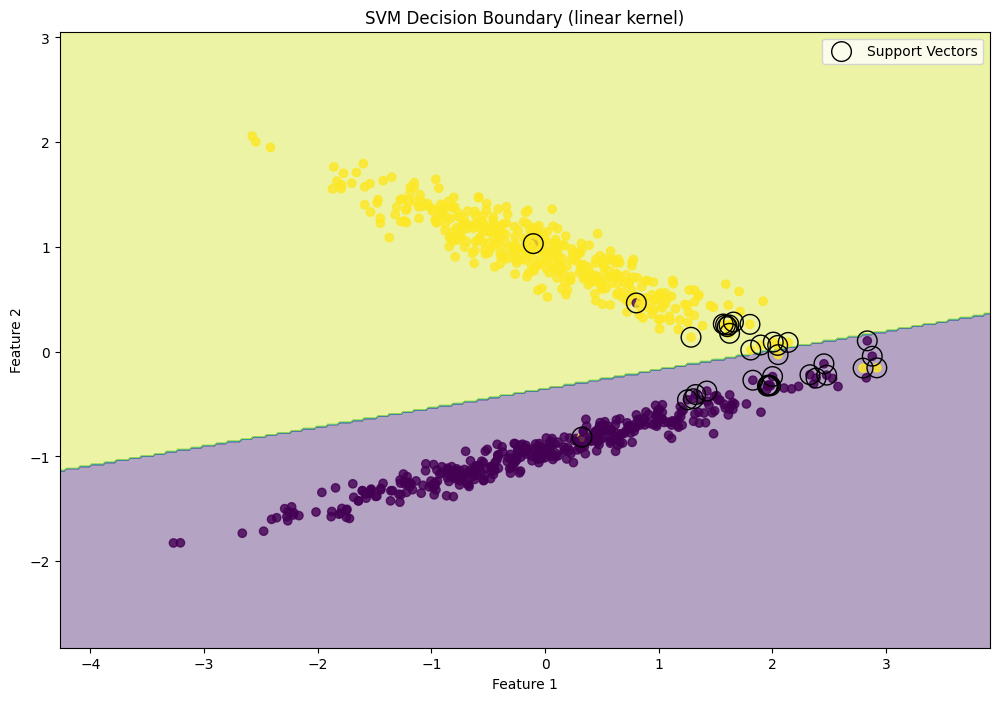

Evaluating model performance...
Model Accuracy: 0.9950
Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      0.99      1.00       104
     Class 1       0.99      1.00      0.99        96

    accuracy                           0.99       200
   macro avg       0.99      1.00      0.99       200
weighted avg       1.00      0.99      1.00       200



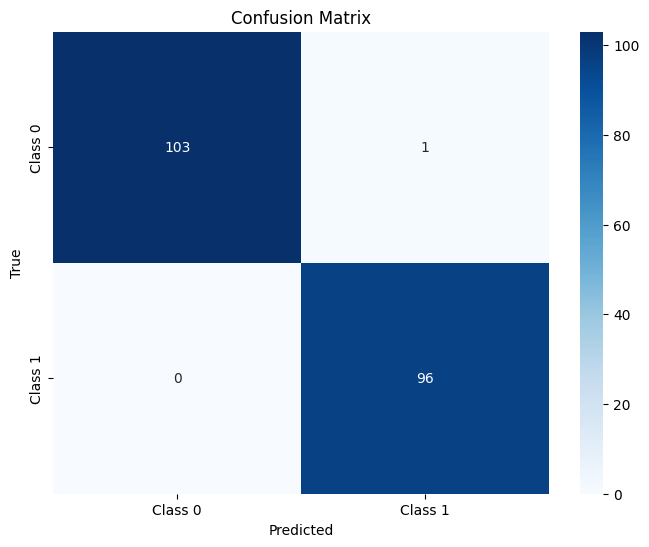

Sample prediction: Class 1
Training and evaluating SVM with rbf kernel.
Training SVM model with rbf kernel...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters for rbf kernel: {'C': 10, 'class_weight': None, 'gamma': 1}
Best cross-validation score: 0.9938


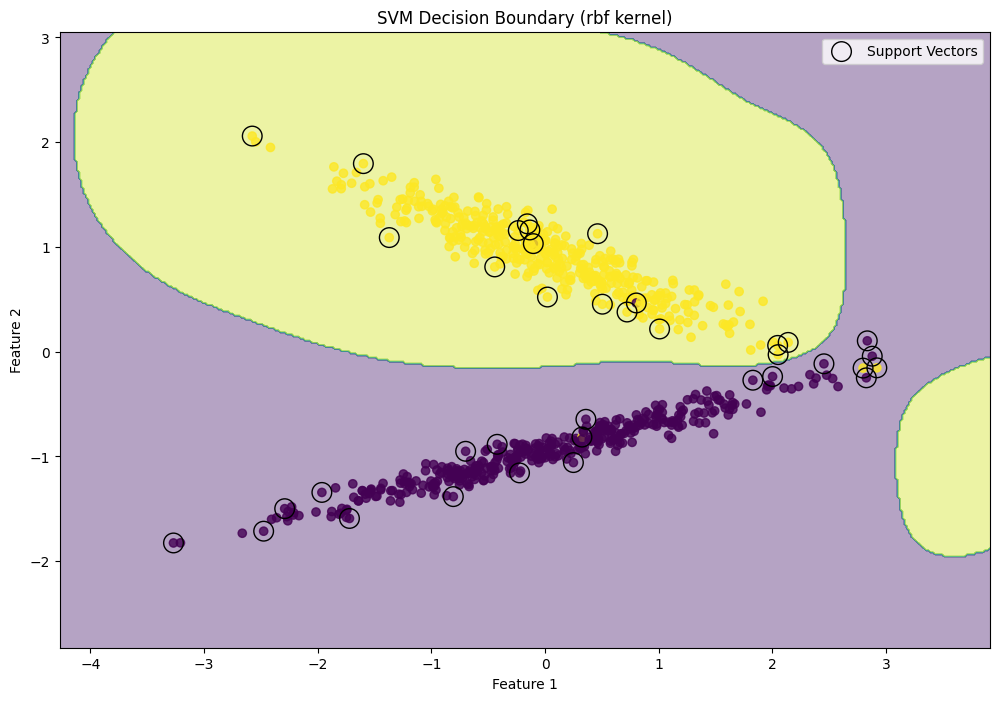

Evaluating model performance...
Model Accuracy: 0.9950
Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      0.99      1.00       104
     Class 1       0.99      1.00      0.99        96

    accuracy                           0.99       200
   macro avg       0.99      1.00      0.99       200
weighted avg       1.00      0.99      1.00       200



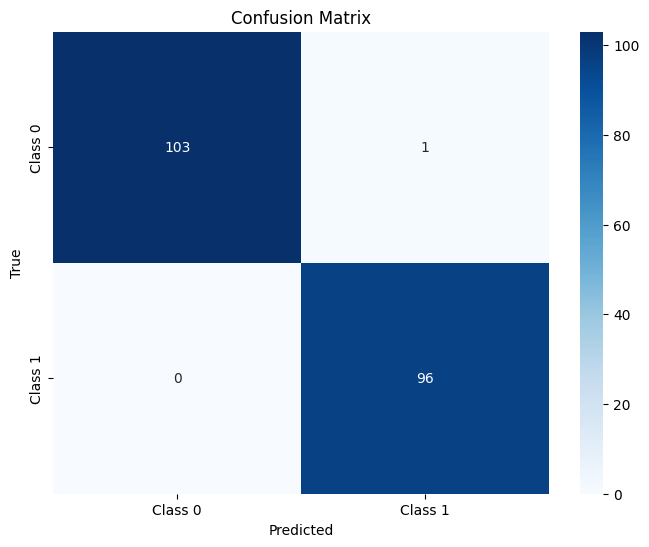

Sample prediction: Class 1
Training and evaluating SVM with poly kernel.
Training SVM model with poly kernel...
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters for poly kernel: {'C': 0.1, 'class_weight': None, 'degree': 3, 'gamma': 'scale'}
Best cross-validation score: 0.9900


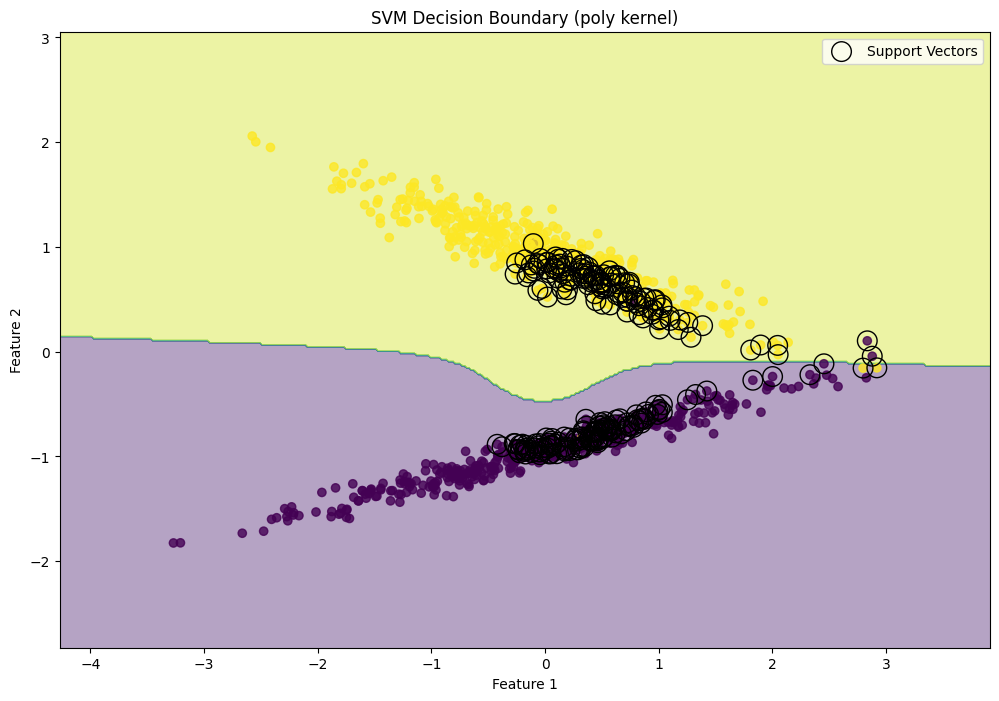

Evaluating model performance...
Model Accuracy: 0.9950
Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      0.99      1.00       104
     Class 1       0.99      1.00      0.99        96

    accuracy                           0.99       200
   macro avg       0.99      1.00      0.99       200
weighted avg       1.00      0.99      1.00       200



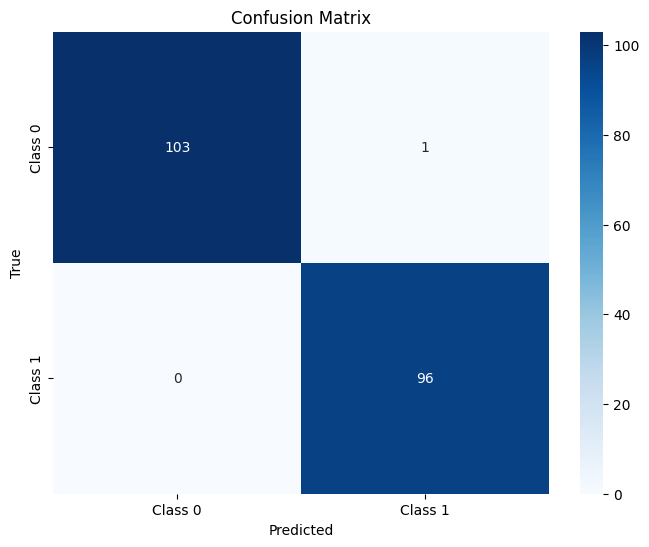

Sample prediction: Class 1
Script execution completed.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.datasets import make_classification
import seaborn as sns
import logging
import os

# Ensure logs directory exists
os.makedirs("logs", exist_ok=True)

# Define log file path
log_file_path = os.path.join("logs", "logs.txt")

# Configure logging
logging.basicConfig(filename=log_file_path, level=logging.INFO,
                    format="%(asctime)s - %(levelname)s - %(message)s",
                    filemode="w")  # "w" overwrites; use "a" to append logs

def log_message(message):
    """Helper function to log and print messages."""
    print(message)  # Print to console
    logging.info(message)
    logging.shutdown()  # Ensure log is written

def generate_data(n_samples=1000, n_features=2, n_classes=2):
    """Generate sample classification data."""
    log_message(f"Generating dataset with {n_samples} samples, {n_features} features, {n_classes} classes.")
    X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_redundant=0,
        n_informative=n_features,
        n_clusters_per_class=1,
        n_classes=n_classes,
        class_sep=2.0,
        random_state=42
    )
    return train_test_split(X, y, test_size=0.2, random_state=42)

def preprocess_data(X_train, X_test):
    """Scale features using StandardScaler."""
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    log_message("Data preprocessing completed.")
    return X_train_scaled, X_test_scaled, scaler

def train_svm_model(X_train, y_train, kernel='rbf'):
    """Train SVM with hyperparameter tuning."""
    log_message(f"Training SVM model with {kernel} kernel...")

    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.1, 1],
        'class_weight': [None, 'balanced']
    }

    if kernel == 'poly':
        param_grid['degree'] = [2, 3, 4]

    svm = SVC(kernel=kernel, random_state=42)
    grid_search = GridSearchCV(
        svm, 
        param_grid, 
        cv=5, 
        n_jobs=-1,
        scoring='accuracy',
        verbose=1
    )
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    log_message(f"Best parameters for {kernel} kernel: {best_params}")
    log_message(f"Best cross-validation score: {grid_search.best_score_:.4f}")

    return grid_search.best_estimator_

def plot_decision_boundary(model, X, y, title="SVM Decision Boundary"):
    """Plot the decision boundary and data points."""
    plt.figure(figsize=(12, 8))

    # Create mesh grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    # Get predictions for mesh grid points
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot decision boundary and margins
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)

    # Plot support vectors
    plt.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=200, linewidth=1, facecolors='none',
                edgecolors='k', label='Support Vectors')

    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes=None):
    """Plot confusion matrix."""
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def evaluate_model(model, X_test, y_test, classes=None):
    """Evaluate model performance."""
    log_message("Evaluating model performance...")

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    log_message(f"Model Accuracy: {accuracy:.4f}")
    log_message(f"Classification Report:\n{classification_report(y_test, y_pred, target_names=classes)}")

    plot_confusion_matrix(y_test, y_pred, classes)

def main():
    log_message("Starting SVM classification script...")

    # Generate data
    X_train, X_test, y_train, y_test = generate_data()

    # Preprocess data
    X_train_scaled, X_test_scaled, scaler = preprocess_data(X_train, X_test)

    # Train models with different kernels
    kernels = ['linear', 'rbf', 'poly']
    classes = ['Class 0', 'Class 1']

    for kernel in kernels:
        log_message(f"Training and evaluating SVM with {kernel} kernel.")
        svm_model = train_svm_model(X_train_scaled, y_train, kernel)

        # Plot decision boundary
        plot_decision_boundary(
            svm_model, 
            X_train_scaled, 
            y_train,
            f"SVM Decision Boundary ({kernel} kernel)"
        )

        # Evaluate model
        evaluate_model(svm_model, X_test_scaled, y_test, classes)

        # Example prediction
        sample = X_test_scaled[0].reshape(1, -1)
        prediction = svm_model.predict(sample)
        log_message(f"Sample prediction: {classes[prediction[0]]}")

    log_message("Script execution completed.")

if __name__ == "__main__":
    main()